## Titanic Data Set Prediction
__Downloaded from kaggle__

05/08/2020

In [1]:
import torch
import numpy as np
from torch import nn,optim
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt

#### Two functions to process the initial data

In [2]:
def dataConvert(data):
    for i in range(len(data)):
        if data[i]=='male':
            data[i] = '1'
        elif data[i]=='female':
            data[i] = '0'
    return data

def fillBlank(data):
    for i in range(len(data)):
        if data[i]=='':
            data[i] = 100000
    return data

#### Construct my own dataset and devided it into two parts: __training set & validation set__

In [3]:
class MyDataset(Dataset):
    def __init__(self,path):
        data = np.loadtxt(path, delimiter=',',dtype=np.str, skiprows=1)
        data[:,5] = dataConvert(data[:,5])
        data[:,6] = fillBlank(data[:,10])
        self.x_data = torch.from_numpy(data[:,[2,5,6,7,8,10]].astype(np.float32))
        self.y_data = torch.from_numpy(data[:,1].astype(np.int64))
        self.len = len(self.y_data)
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len
    
datas = MyDataset('train.csv')
val_set_size = int(datas.len/5)
train_set_size = datas.len - val_set_size
train_set, val_set = torch.utils.data.random_split(datas,[train_set_size,val_set_size])

train_loader = DataLoader(dataset=train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=8, shuffle=True)

#### Construct a Multilayer Perceptron to achieve machine learning
##### Including several linear layers and apply dropout to prevent overfitting

In [4]:
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self):
        super(Model,self).__init__()
        self.fc1 = nn.Linear(6,18)
        self.fc2 = nn.Linear(18,64)
        self.fc3 = nn.Linear(64,10)
        self.fc4 = nn.Linear(10,4)
        self.fc5 = nn.Linear(4,2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self,x):
        x = self.dropout(F.elu(self.fc1(x)))
        x = self.dropout(F.elu(self.fc2(x)))
        x = self.dropout(F.elu(self.fc3(x)))
        x = self.dropout(F.elu(self.fc4(x)))
        x = self.fc5(x)
        return x
    
model = Model()

In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.0005)
loss_list = []
loss_list_val = []

In [12]:
optimizer = optim.Adam(model.parameters(),lr=0.0001)
running_loss = 0
for e in range(100):
    for x,y in iter(train_loader):
        model.train()
        optimizer.zero_grad()
        
        y_pred = model(x)
        loss = criterion(y_pred,y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_list.append(running_loss/len(train_loader))
    running_loss = 0
    
    for x,y in iter(val_loader):
        model.eval()
        y_pred = model(x)
        
        loss = criterion(y_pred,y)
        running_loss += loss.item()
        
    loss_list_val.append(running_loss/len(val_loader))
    running_loss = 0
    
    print('epoch NO.{}\tloss = {}\ttest_loss = {}'.format(e,loss_list[-1],loss_list_val[-1]))

epoch NO.0	loss = 0.4668258294463158	test_loss = 0.39375494906435843
epoch NO.1	loss = 0.46882780955897435	test_loss = 0.4297351565050042
epoch NO.2	loss = 0.4518706201679177	test_loss = 0.4435365569332372
epoch NO.3	loss = 0.4380183315939373	test_loss = 0.3967190138671709
epoch NO.4	loss = 0.456928727361891	test_loss = 0.3942221186083296
epoch NO.5	loss = 0.44736722997493217	test_loss = 0.405096512125886
epoch NO.6	loss = 0.4488166831433773	test_loss = 0.4093465260837389
epoch NO.7	loss = 0.4439224794507027	test_loss = 0.395009051522483
epoch NO.8	loss = 0.46030619310008153	test_loss = 0.3995195536509804
epoch NO.9	loss = 0.4550591920812925	test_loss = 0.4303443587344626
epoch NO.10	loss = 0.463736012743579	test_loss = 0.4020849427451258
epoch NO.11	loss = 0.4589181454645263	test_loss = 0.4299700571143109
epoch NO.12	loss = 0.4541561974419488	test_loss = 0.4150223997624024
epoch NO.13	loss = 0.4703472332821952	test_loss = 0.40349424014920776
epoch NO.14	loss = 0.44841693888107936	test

Text(0, 0.5, 'loss')

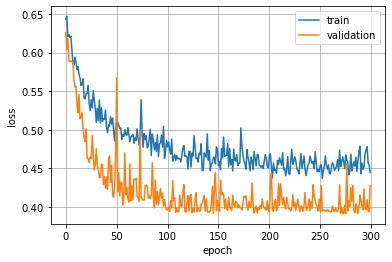

In [13]:
plt.plot(loss_list,label='train')
plt.plot(loss_list_val, label='validation')
plt.legend()
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')

#### After training the model, now apply it to cast prediction on test set

In [14]:
testdata = MyDataset('./test.csv')
model.eval()
y_pred = model(testdata.x_data)
pred = np.zeros(len(y_pred))

for i in range(len(pred)):
    if y_pred[i,0]>y_pred[i,1]:
        pred[i] = int(0)
    else:
        pred[i] = int(1)
        
pred = pred.astype(np.int64)

#### Save the prediction data

In [16]:
pred_ = np.loadtxt('submission.csv', delimiter=',',dtype=np.str)
pred_ = pred_[1:].astype(np.float32)
pred_[:,1] = pred
pred_ = pred_.astype(np.int64)
np.savetxt('submission_.csv',pred_, delimiter=',',fmt='%d')